In [127]:
import pandas as pd
import time
import datetime
import plotly.express as px
from pathlib import Path
import torch
from lib.models import MLP2hl
from lib.modules import evaluate_loop, plot_and_save_cm, summary, window_session, pad_for_windowing, predict_and_plot_pretty_session
from lib.utils import get_bouts_smoothed
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [110]:
data_dir = Path('../data/andrew/2023-10-26_15_32_20/')
acceleration = pd.read_csv(data_dir / 'acceleration.csv',skiprows=1)
acceleration_start_time_seconds = float(pd.read_csv(data_dir / 'acceleration.csv',nrows=1,header=None).iloc[0,0].split()[-1])/1000
acceleration.timestamp = ((acceleration.timestamp - acceleration.timestamp[0])*1e-9)+acceleration_start_time_seconds
acceleration = acceleration.iloc[:-1]   # nans on last row

start = int(datetime.datetime(2023, 10, 26, 16, 20, 0).strftime('%s'))
end = int(datetime.datetime(2023, 10, 26, 16, 37, 0).strftime('%s'))
acceleration['label'] = 0
acceleration.loc[(acceleration.timestamp > start) & (acceleration.timestamp < end),'label'] = 1

In [112]:
WINSIZE = 101
DEVICE = 'cuda:1'

In [113]:
Xte = torch.Tensor(acceleration[['x','y','z']].values)
yte = torch.Tensor(acceleration['label'].values).unsqueeze(1)

Xte = pad_for_windowing(Xte, WINSIZE)
Xte = window_session(Xte, WINSIZE)

In [115]:
model = MLP2hl([20,20], WINSIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [116]:
# model.load_state_dict(torch.load(Path('dev/mlp2hl/best_model.pt')))
model.load_state_dict(torch.load(Path('dev/mlp2hl/best_model.pt')))

<All keys matched successfully>

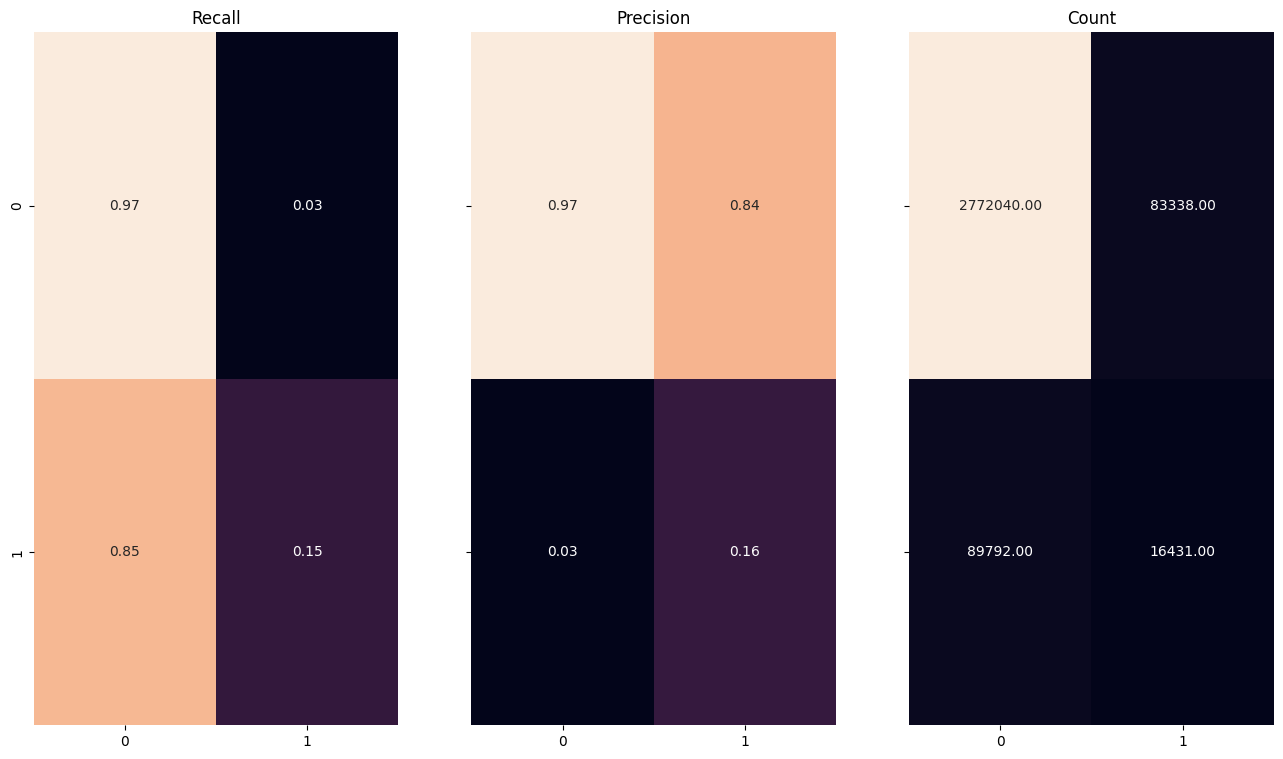

Metric        Value
---------  --------
loss       0.199897
precision  0.16469
recall     0.154684
f1         0.15953


In [117]:
testloader = DataLoader(TensorDataset(Xte,yte), batch_size=64)
ys,metrics = evaluate_loop(model, criterion, testloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

In [142]:
session = acceleration[['x','y','z']]
session.columns = ['x_acc', 'y_acc', 'z_acc']

session['Predicted Eating'] = ys['pred']
session['Confidence'] = ys['conf']

pred_bouts = get_bouts_smoothed(ys['pred'])

fig = px.line(
    session[::10], 
    x=session.index[::10], 
    y=['x_acc','y_acc','z_acc', 'Predicted Eating', 'Confidence']
)
fig.add_vrect(
    x0=(acceleration['label'] == 1).argmax(), 
    x1=(acceleration['label'] == 1)[::-1].argmax(), 
    fillcolor='black', 
    opacity=.2,
    line_width=0,
    layer="below"
)
for bout in pred_bouts:
    fig.add_vrect(
        x0=bout['start'], 
        x1=bout['end'], 
        fillcolor='red', 
        opacity=.2,
        line_width=0,
        layer="below"
    )
fig.show(renderer='browser')

/tmp/ipykernel_106294/1312670384.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

